## Runnning with gammapy-dev/IRF_model
Fitting asimov datasets with nuisance parameters based on the different livetimes

### Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets, FluxPointsDataset
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SkyModel,
    PointSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    PiecewiseNormSpectralModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator
from gammapy.estimators import FluxPoints, FluxPointsEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys
sys.path.append('../../')
import Dataset_load 

from  Dataset_Setup import Setup, GaussianCovariance_matrix

## Read dataset

In [2]:
config = Dataset_load.load_config()
colors = config['colors']['three']

colors
import ast

colors[1] = ast.literal_eval(colors[1])
colors[2] = ast.literal_eval(colors[2])
colors[3] = ast.literal_eval(colors[3])

In [3]:
livetimes = np.logspace(0, 2,  7)[1:2]
print(livetimes)

[2.15443469]


In [4]:
%%time
datasets_input = []
for l in livetimes:
    datasets_i  = Dataset_load.create_asimov(model = 'crab', source = "PKSflare", 
                                                   livetime = f"{l}-hr",
                                            parameters = None)
    datasets_input.append(datasets_i)

loaded dataset:
/home/katrin/Documents/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-2.154434690031884-hr.fits.gz
CPU times: user 5.36 s, sys: 341 ms, total: 5.7 s
Wall time: 5.75 s


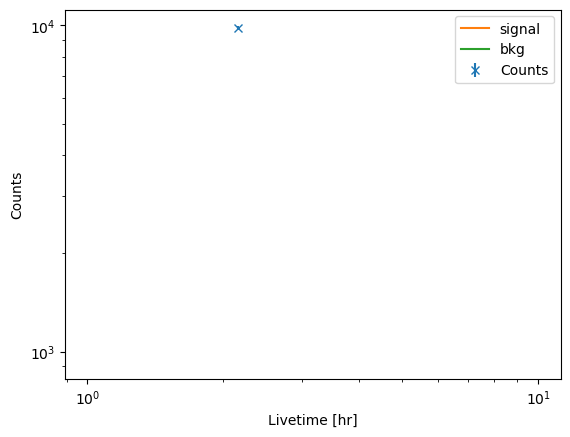

In [5]:
counts, signal, bkg = [] , [], []
for d in datasets_input:
    counts.append(d.counts.data.sum())
    signal.append(d.npred_signal().data.sum())
    bkg.append(d.npred_background().data.sum())
    
    
plt.errorbar(livetimes, counts, yerr = np.sqrt(counts), fmt= 'x', label = "Counts")
plt.plot(livetimes, signal, label = "signal")
plt.plot(livetimes, bkg, label = "bkg")

plt.loglog()
plt.xlabel("Livetime [hr]")
plt.ylabel("Counts")
plt.legend()

## Asimov Cases

In [6]:
true_energy = datasets_input[0].exposure.geom.axes[0].center.value

## Datasets

In [7]:
true_energy = datasets_input[0].exposure.geom.axes[0].center.value
zero = 1e-12
norm = 0.1
tilt = 0.02
bias = 0.1
resolution =  0 
magnitude  = .1
corrlength = 2

In [8]:
def set_up(dataset_input):
    
    setup = Setup(dataset_input=dataset_input)
    #setup.set_up_irf_sys(bias, resolution, norm, tilt)
    dataset_asimov, dataset_asimov_N = setup.run()
    # irf model
    setup.set_irf_model(dataset_asimov_N)
    dataset_asimov_N.models.parameters['resolution'].frozen = True
    dataset_asimov_N.irf_model.parameters['tilt'].frozen = False
    dataset_asimov_N.irf_model.parameters['bias'].frozen = False
    
    setup.set_irf_prior(dataset_asimov_N, bias, resolution, norm, tilt)
    # piece wise model
    # remove old bkg model
    #setup.unset_model(dataset_asimov_N, FoVBackgroundModel)
    #setup.set_piecewise_bkg_model(dataset_asimov_N)
    # energy of the following parameters smaller than ethrshold
    #dataset_asimov_N.background_model.parameters['norm0'].frozen = True
    #dataset_asimov_N.background_model.parameters['norm1'].frozen = True
    #dataset_asimov_N.background_model.parameters['norm2'].frozen = True
    #dataset_asimov_N.background_model.parameters['norm3'].frozen = True
    #setup.set_bkg_prior(dataset_asimov_N, magnitude, corrlength)

    print(dataset_asimov_N.models)
    
       
    return dataset_asimov_N, dataset_asimov

In [9]:
datasets_N = []
datasets = []
for d in datasets_input:
    dataset_asimov_N, dataset_asimov = set_up(d)
    datasets_N.append(dataset_asimov_N)
    datasets.append(dataset_asimov)

DatasetModels

Component 0: SkyModel

  Name                      : Crab
  Datasets names            : None
  Spectral model type       : ExpCutoffPowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.390   +/-    0.00             
    amplitude                     :   3.76e-11   +/- 0.0e+00 1 / (TeV s cm2)
    reference             (frozen):      1.000       TeV         
    lambda_                       :      0.070   +/-    0.00 1 / TeV     
    alpha                 (frozen):      1.000                   
    lon_0                         :    329.680   +/-    0.00 deg         
    lat_0                         :    -30.222   +/-    0.00 deg         

Component 1: FoVBackgroundModel

  Name                      : 2SdNzGJW-bkg
  Datasets names            : ['2SdNzGJW']
  Spectral model type       : PowerLawNormSpectralModel
  Parameters:
    norm                          :      1.

In [10]:
datasets

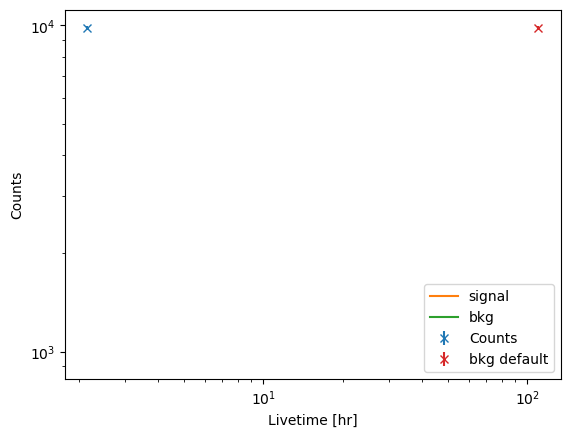

In [11]:
counts, signal, bkg = [] , [], []
for d in datasets_input:
    counts.append(d.counts.data.sum())
    signal.append(d.npred_signal().data.sum())
    bkg.append(d.npred_background().data.sum())
    
    
plt.errorbar(livetimes, counts, yerr = np.sqrt(counts), fmt= 'x', label = "Counts")
plt.plot(livetimes, signal, label = "signal")
plt.plot(livetimes, bkg, label = "bkg")
counts = dataset_asimov.counts.data.sum() 

plt.errorbar(110,counts, yerr = np.sqrt(counts) , fmt= 'x', label = "bkg default")


plt.loglog()
plt.xlabel("Livetime [hr]")
plt.ylabel("Counts")
plt.legend()

In [12]:
print(datasets_N[0].models)

DatasetModels

Component 0: SkyModel

  Name                      : Crab
  Datasets names            : None
  Spectral model type       : ExpCutoffPowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.390   +/-    0.00             
    amplitude                     :   3.76e-11   +/- 0.0e+00 1 / (TeV s cm2)
    reference             (frozen):      1.000       TeV         
    lambda_                       :      0.070   +/-    0.00 1 / TeV     
    alpha                 (frozen):      1.000                   
    lon_0                         :    329.680   +/-    0.00 deg         
    lat_0                         :    -30.222   +/-    0.00 deg         

Component 1: FoVBackgroundModel

  Name                      : 2SdNzGJW-bkg
  Datasets names            : ['2SdNzGJW']
  Spectral model type       : PowerLawNormSpectralModel
  Parameters:
    norm                          :      1.

In [13]:
%%time
fitting = 1


if fitting:
    for i, d in enumerate(datasets_N):
        print(i)
        fit_cor = Fit(store_trace=0)
        result_cor = fit_cor.run(d)
        print(result_cor)
        print("saving")
        path = f'data/2_model_nui_livetime_{livetimes[i]}_bias.yml'
        d.models.write(path,overwrite=True)
    
else:
    print("read")
    for i, d in enumerate(datasets_N):
        path = f'data/2_model_nui_livetime_{livetimes[i]}_bias.yml'
        print(path)
        datasets_N[i] = Dataset_load.load_dataset_N(d, path,bkg_sys = False)        
        datasets_N[i].models.parameters['tilt'].frozen = False 
    

#39min 32

0
OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 866
	total stat : 89307.15

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

saving
CPU times: user 19min 20s, sys: 12min 44s, total: 32min 4s
Wall time: 9min 27s


In [ ]:
print("read")
datasets = []
for i, d in enumerate(datasets_N):
    path = f'data/2_model_livetime_{livetimes[i]}.yml'
    da = Dataset_load.load_dataset(d, path)     
    datasets.append(da)

In [ ]:
def plot_par(par1, par2, label,ax = None, fmt ='x', markersize = 6, color = 'red'):
    if ax is None:
        fig, ax = plt.subplots(1,1)
    ax.errorbar(x = par1.value, y = par2.value, xerr = par1.error, yerr = par2.error, fmt= fmt,
                markersize = markersize,
                label = label, color = color)
    ax.set_xlabel(f"{par1.name} [{par1.unit}] " )
    ax.set_ylabel(f"{par2.name} [{par2.unit}] " )
    ax.legend()
    
    return ax

def plot_source_par(model_name, pars):
    if len(pars)>2:
        fig, ax = plt.subplots(2,2, figsize = (6,6))
        ax = ax.flatten()
    else:
        fig, ax = plt.subplots(1,2, figsize = (6,3))
   
    for i, p in enumerate(pars):
    
        for j, m in enumerate (models_list):
            #try:
            plot_par(m.parameters[p[0]],
                 m.parameters[p[1]],
                    label= labels[j],
                    ax = ax[i],
                    fmt = fmts[j],
                    markersize = markersize[j], 
                        color = colors_default [j])
            #except:
            #    pass

    plt.tight_layout()
    return fig

fmts = ['o','x', '*']*3
markersize = [6,10, 10] * 3

In [ ]:
labels = [str(int(l)) for l in livetimes]
colors_default =  plt.rcParams['axes.prop_cycle'].by_key()['color']

In [ ]:
models_list = [ d.irf_model for d in datasets_N]
pars =   [('bias', 'resolution'), ('norm', 'tilt')]
fig = plot_source_par(0, pars)

In [ ]:
i = 0
fig,axs = plt.subplots(2,1)
for l, m in zip(livetimes, models_list):
    axs[0].plot(l, m.parameters[pars[0][0]].error, 'x', label = "bias", color = colors_default[i])
    axs[0].plot(l, m.parameters[pars[0][1]].error, 'o' , label = "resolution", color = colors_default[i])
    axs[1].plot(l, m.parameters[pars[1][0]].error, 'x' , label = "norm", color = colors_default[i])
    axs[1].plot(l, m.parameters[pars[1][1]].error, 'o' , label = "tilt", color = colors_default[i])
    i +=1
    
    
axs[0].plot([livetimes[0],livetimes[-1]], [bias, bias])
axs[0].plot([livetimes[0],livetimes[-1]], [resolution, resolution])
axs[1].plot([livetimes[0],livetimes[-1]], [norm, norm])
axs[1].plot([livetimes[0],livetimes[-1]], [tilt, tilt])  

for a in axs:
    a.set_xscale("log")
    a.legend()


    from collections import OrderedDict

    handles, labels = a.get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    a.legend(by_label.values(), by_label.keys())
    
axs[0].set_ylim(-0.01, 0.2)

In [ ]:
inputvalues = {"amplitude":datasets_input[0].models[0].parameters['amplitude'].value,
               "index":datasets_input[0].models[0].parameters['index'].value ,
               "lambda_":datasets_input[0].models[0].parameters['lambda_'].value}
def plotting(parname = "amplitude"):
    fig = plt.figure(figsize  = (5,3))
    inputvalue = inputvalues[parname]
    
    errs = []
    errs_N = []
    livetimes_ext = livetimes.copy(); livetimes_ext2 = livetimes.copy(); 
    livetimes_ext[-1] *=1.1;
    livetimes_ext2[0:,] *=1.1; 
    livetimes_ext2 = np.insert(livetimes_ext2, 0, values =  livetimes_ext2[0]* 0.9)


    for i, d in enumerate(datasets_N):
        par = datasets[i].models[0].parameters[parname]
        val, err = par.value, par.error
        errs.append( err/ inputvalue)
        plt.errorbar(livetimes[i], val/ inputvalue, yerr = err/ inputvalue,  fmt='x', 
                     color = colors[0])

        par = d.models[0].parameters[parname]
        val, err = par.value, par.error
        errs_N.append( err/ inputvalue)
        plt.errorbar( 1.1* livetimes[i] , val/ inputvalue, yerr = err/ inputvalue,  fmt='x', 
                     color = colors[1])

    

    errs_N = np.insert(errs_N, 0, values =  errs_N[0])
    plt.fill_between(  livetimes_ext2, 1- np.array(errs_N), 1+np.array(errs_N) 
                     ,color = colors[1], alpha = 0.3, label = '')
    plt.fill_between( livetimes_ext, 1- np.array(errs), 1+np.array(errs)
                     ,color = colors[0], alpha = 0.2, label = '')

    plt.errorbar( np.nan, np.nan , yerr = np.nan, fmt='x', color = colors[0],
                 label = 'Without nuisance par.')
    plt.errorbar( np.nan, np.nan , yerr = np.nan, fmt='x', color = colors[1], 
                 label = 'With nuisance par.')
    ax1 = plt.gca()
    xlim = ax1.get_xlim()
    plt.hlines(1, xlim[0], xlim[1], color = 'lightgrey')
    #plt.title("Best Fit Amplitude")
    plt.legend()
    plt.xscale('log')
    plt.xlabel("Livetime [hr]")
    plt.ylabel(f"Best-fit {parname} [Input {parname}]")

    ax2 = ax1.twiny()
    ax2.set_xscale("log")
    npred = [d.npred_signal().data.sum() for d in datasets]
    
    ax2.set_xlim(ax1.get_xlim())
    ax2.set_xticks(livetimes)
    clabels = [ f'{int(c)}' for c in npred]
    ax2.set_xticklabels(clabels)
    ax2.set_xlabel(r"Signal Counts")
    plt.tight_layout()
    return fig

fig = plotting(parname = "amplitude")
fig.savefig('plots/2_best_fit_vs_livetime.svg')
fig.savefig('plots/2_best_fit_vs_livetime.pdf')
fig.savefig('plots/2_best_fit_vs_livetime.png')

In [ ]:
fig = plotting(parname = "index")
fig.savefig('plots/2_best_fit_vs_livetime_index.svg')
fig.savefig('plots/2_best_fit_vs_livetime_index.pdf')
fig.savefig('plots/2_best_fit_vs_livetime_index.png')

In [ ]:
fig = plotting(parname = "lambda_")
fig.savefig('plots/2_best_fit_vs_livetime_lambda_.svg')
fig.savefig('plots/2_best_fit_vs_livetime_lambda_.pdf')
fig.savefig('plots/2_best_fit_vs_livetime_lambda_.png')

In [ ]:

energy_power = 2
for i, d in enumerate(datasets):
    fig = plt.figure()
    dataset = datasets[i]
    dataset_N = datasets_N[i]
    
    ax =  dataset_N.models[0].spectral_model.plot((0.1, 100) *u.TeV, energy_power = energy_power)    
    dataset_N.models[0].spectral_model.plot_error((0.1, 100) *u.TeV,energy_power = energy_power, ax = ax, 
                                               facecolor= 'tab:blue', alpha = 0.5)
    dataset.models[0].spectral_model.plot_error((0.1, 100) *u.TeV,energy_power = energy_power, ax = ax, 
                                               facecolor= 'tab:orange')
    dataset.models[0].spectral_model.plot_error((0.1, 100) *u.TeV,energy_power = energy_power, ax = ax, 
                                               facecolor= 'tab:orange', alpha = 0.5)
    ax.set_title(str(livetimes[i]) + " hr")
    
    

In [ ]:
par_names = ['index', 'amplitude', 'lambda_', 'bias', 'resolution', 'norm_nuisance' , 
            'tilt_nuisance']
names =  ['index', 'amplitude',  
        'bkg norm', 'bkg tilt',
          'bias', 'resolution',
          'eff. area norm' , 
            'eff. area tilt']
for i in range(len(livetimes)):

    #datasets_N[i].models.read_covariance("data", f"8_model_nui_livetime_{livetimes[i]}_covariance.dat", format="ascii.fixed_width")
    parameters = Parameters([_ for _ in datasets_N[i].models.parameters if _.name in par_names])
    cov_par = datasets_N[i].models.covariance.get_subcovariance(parameters)
    ax = cov_par.plot_correlation()
    ax.set_title(str(livetimes[i]) + " hr")
    fig = plt.gcf()
    fig.savefig(f"plots/2_covmatrix_livetime_{livetimes[i]}.svg")
    fig.savefig(f"plots/2_covmatrix_livetime_{livetimes[i]}.pdf")
    
